In [26]:
# Notebook to prototype iteratively aligning the points by finding correspondences and
# and transforming the paths
from __future__ import division
from os.path import join
import cPickle as pickle

with open("../dataset_loc", 'r') as f:
    dataset_loc = f.read().rstrip()

with open(join(dataset_loc, "Flukes/zooniverse_curvatures_winteg.pkl"), 'r') as f:
    curvatures = pickle.load(f)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def visualize_paths(path1, path2):
    p1 = np.array(path1)
    p2 = np.array(path2)
    y_extent = max(np.max(np.abs(p1[:,1])), np.max(np.abs(p2[:,1])))
    # assume x_extent is 960
    image = np.ones((y_extent*2, 960, 3), dtype=np.uint8) * 255
    image[y_extent,:,:] = 0
    for point in p1:
        image[(y_extent-1) - point[1],point[0],:] = np.array([255,0,0])
    for point in p2:
        image[(y_extent-1) - point[1],point[0],:] = np.array([0,255,0])
    plt.figure(figsize=(15,15))
    plt.imshow(image[::-1,:,:])
    
    

In [91]:
from itertools import product

eqpairs = []
uneqpairs = []
for c1, c2 in product(curvatures, curvatures):
    if c1['id'] == c2['id']:
        eqpairs.append((c1, c2))
    else:
        uneqpairs.append((c2, c2))



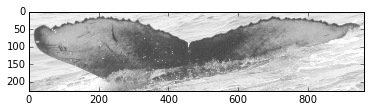

In [84]:
import cv2
imgs_dir = join(dataset_loc, 'Flukes/CRC_combined constrained')
plt.imshow(cv2.imread(join(imgs_dir, c1['fn'])))

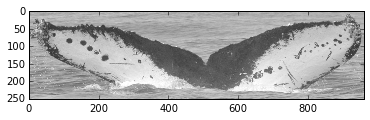

In [85]:
plt.imshow(cv2.imread(join(imgs_dir, c2['fn'])))

/home/zach/envs/thesis/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/zach/envs/thesis/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/zach/envs/thesis/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


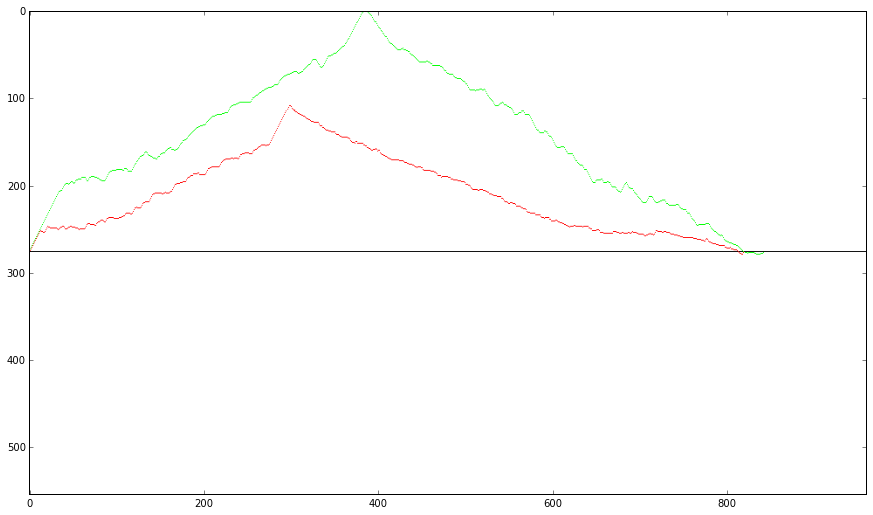

In [6]:
# So we want to do the following: given two paths, figure out an initial alignment
# find the line between the two end points, and rotate both lines so that the 
# slope of the line between the two end points is 0
# then we can translate both so that they lie on the x-axis
# then we can translate both so that the start point is at 0,0
# this is the initial alignment to the canonical coordinate system

def rotate_path(path, theta):
    #rotation_mat = np.hstack([
    rotation_mat = np.array(
                      [[np.cos(theta), -1*np.sin(theta)], 
                      [np.sin(theta), np.cos(theta)]])
            #translation.reshape(2,1)])
    #print(rotation_mat)
    #augmented_path = np.vstack([path.T, np.ones(path.shape[0])])
    augmented_path = path.T
    rotated_path = np.dot(rotation_mat, augmented_path).T[:,::-1]
    return rotated_path


def canonical_transform(p1, p2):
    p1 = np.array(p1)
    p2 = np.array(p2)
    offset1 = p1[-1]
    offset2 = p2[-1]
    
    p1_centered = p1 - offset1
    p2_centered = p2 - offset2
    #print(offset1)
    #print(offset2)
    
    rotation1 = np.arctan2(*(p1_centered[0]))
    rotation2 = np.arctan2(*(p2_centered[0]))
    #print(180*rotation1 / np.pi)
    #print(180*rotation2 / np.pi)
    p1_rotated = rotate_path(p1_centered, rotation1)
    p2_rotated = rotate_path(p2_centered, rotation2)
    return p1_rotated, p2_rotated


visualize_paths(*canonical_transform(c1['path'], c2['path']))

(819, 2)
(842, 2)
54023.9


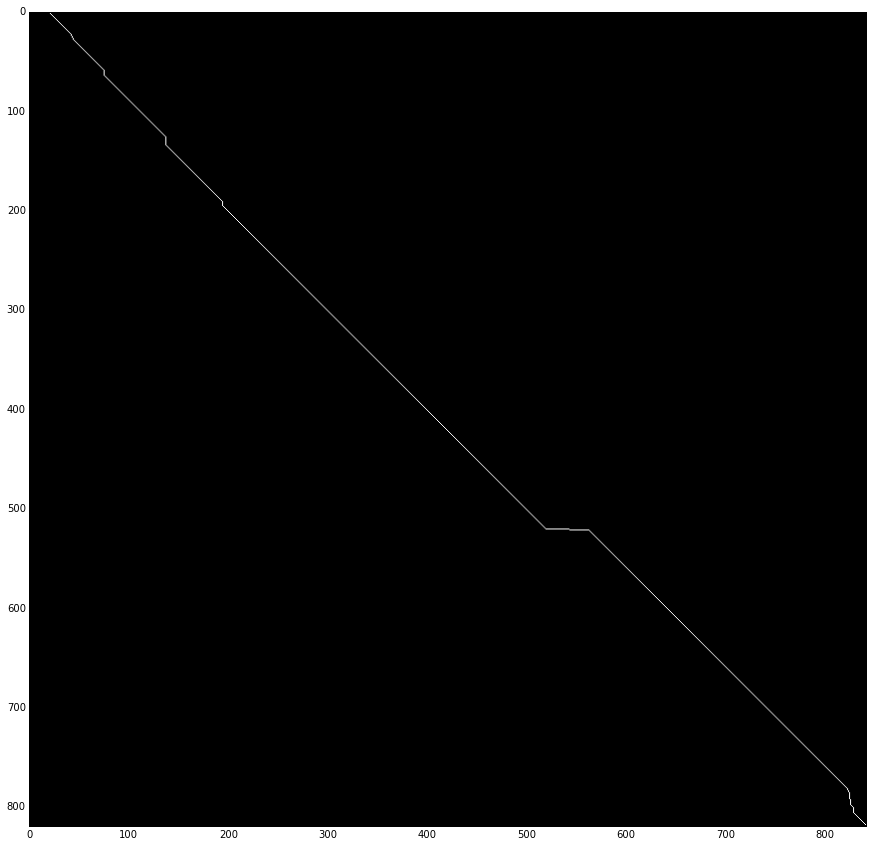

In [7]:
import ctypes
dtw_lib = ctypes.cdll.LoadLibrary('../edge_match/icp_ctypes_cpp/ctypes_icp.so')
dtw_dist = dtw_lib.dtw_windowed
dtw_scalar = dtw_lib.dtw_scalar

def get_dist_mat(aligned1, aligned2):
    seq1_len = aligned1.shape[0]
    seq2_len = aligned2.shape[0]
    
    seq1 = aligned1.astype(np.float32).flatten() + 1e-7
    seq2 = aligned2.astype(np.float32).flatten() + 1e-7
    
    distance_mat = (np.zeros((seq1_len, seq2_len), dtype=np.float32)) + np.inf
    #distance_mat[:,0] = np.inf
    #distance_mat[0,:] = np.inf
    distance_mat = distance_mat.flatten()
    distance_mat[0] = 0
    
    distance = dtw_dist(
                    #ctypes.c_void_p(seq1pos.ctypes.data), ctypes.c_void_p(seq2pos.ctypes.data),
                    ctypes.c_void_p(seq1.ctypes.data), ctypes.c_void_p(seq2.ctypes.data),
                    ctypes.c_int(seq1_len), ctypes.c_int(seq2_len), ctypes.c_int(100),
                    ctypes.c_void_p(distance_mat.ctypes.data))
    return distance_mat.reshape(seq1_len, seq2_len)

def get_neighbors(cell):
    candidate_neighbors = [(cell[0]-1, cell[1]-1),
                           (cell[0], cell[1]-1),
                           (cell[0]-1, cell[1])]
    return list(filter(lambda x: (x[0] >= 0) and
                                 (x[1] >= 0), candidate_neighbors))

def find_path(distance_mat):
    # find the optimal path from the last cell in the distance_mat to the first
    # todo: in the future it might just make sense to store the backtrace in another
    # matrix when the computation is being done
    curcell = (distance_mat.shape[0]-1, distance_mat.shape[1]-1)
    path = [curcell]
    path_info = [0]
    neighbors = get_neighbors(curcell)
    while (curcell != (0,0) and len(neighbors) > 0):
        next_neighbor_ind = np.argmin(distance_mat[zip(*neighbors)])
        if len(neighbors) != 3:
            neighbortype = 4
        else:
            neighbortype = next_neighbor_ind
        next_neighbor = neighbors[next_neighbor_ind]
        path.append(next_neighbor)
        path_info.append(neighbortype)
        curcell = next_neighbor
        neighbors = get_neighbors(curcell)
        #print(path)
        #break
    return path, path_info



p1_c, p2_c = canonical_transform(c1['path'], c2['path'])
print(p1_c.shape)
print(p2_c.shape)
distance_mat = get_dist_mat(p1_c, p2_c)
path, path_info = find_path(distance_mat)
#print(path)
view_path_mat = np.zeros(distance_mat.shape)
view_path_mat[zip(*path)] = 1
plt.figure(figsize=(15,15))
plt.gray()
plt.imshow(view_path_mat)
print(distance_mat[-1,-1])

In [8]:
import plottool as pt

[!plotttool] WARNING guitool does not have __PYQT__


/home/zach/envs/thesis/local/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


/home/zach/envs/thesis/local/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/zach/envs/thesis/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


47.3524


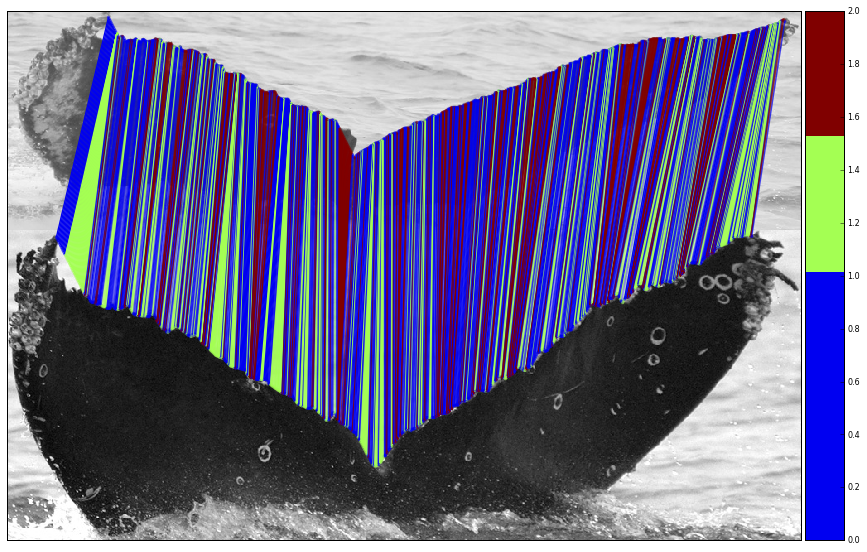

In [9]:

def draw_correspondences(c1, c2):
    # this will take the curvature items, open them
    # draw the compute paths on each image
    # then figure out the alignment between the paths (i.e. which index i into path 1
    # corresponds to some index j in path 2)
    img1 = cv2.imread(join(imgs_dir, c1['fn']))
    img2 = cv2.imread(join(imgs_dir, c2['fn']))
    p1_c, p2_c = canonical_transform(c1['path'], c2['path'])
    #distance_mat = get_dist_mat(p1_c, p2_c)
    distance_mat = get_dist_mat(np.array(c1['int_curv'][5]),
                                np.array(c2['int_curv'][5]))
    path, path_info = find_path(distance_mat)
    print(distance_mat[-1,-1])
    
    # kpts are : x, y, 1, 0, 1, 0
    # shape npoints x 6
    #print(p1_c.astype(np.int))
    invert_y = lambda x, extent: np.array([x[0], extent - x[1]])
    pts1 = np.array([c1['path'][p1_ind] for p1_ind, _ in path])
    pts2 = np.array([c2['path'][p2_ind] for _, p2_ind in path])
    acdtheta = np.zeros((len(path), 4))
    acdtheta[:,0] = 1
    acdtheta[:,2] = 1
    kpts1 = np.hstack([pts1, acdtheta])
    kpts2 = np.hstack([pts2, acdtheta])
    c1_comp = c1['int_curv'][5]
    c2_comp = c2['int_curv'][5]
    max_dist = np.max([np.linalg.norm(np.array(c1_comp[co1]) - np.array(c2_comp[co2])) 
                       for co1, co2 in path])
    dists = [1 - (np.linalg.norm(np.array(c1_comp[co1]) - 
                                 np.array(c2_comp[co2])) / max_dist)
                       for co1, co2 in path]
    #print(np.array(dists))
    pt.show_chipmatch2(img1, img2, kpts1, kpts2, 
                               fs=np.array(path_info),
                               cmap=plt.cm.jet,
                               line_alpha=dists,)
    fig = pt.gcf()
    fig.set_size_inches((15,15))
    """
    combined_img = np.vstack([img1, img2])
    max_dist = np.max([np.linalg.norm(np.array(p1_c[co1]) - np.array(p2_c[co2])) 
                       for co1, co2 in path])
    print(max_dist)
    for (c1_pos, c2_pos), corr_type in zip(path, path_info)[::10]:
        coords_1 = c1['path'][c1_pos]
        coords_2 = c2['path'][c2_pos]
        dist = np.linalg.norm(np.array(coords_1) - np.array(coords_2))
        percentage_of_max = dist / max_dist
        adjusted_coords_2 = (coords_2[0], coords_2[1] + img1.shape[0])
        color_tuple = [0,0,0]
        color_tuple[corr_type] = 255*percentage_of_max
        cv2.line(combined_img, coords_1, adjusted_coords_2, color=tuple(color_tuple))
    plt.figure(figsize=(15,15))
    plt.imshow(combined_img)
    """
draw_correspondences(c1, c2)

In [82]:
def normalize_coords(coords):
    # subtract the mean coordinate
    mean_shifted = coords - np.average(coords, axis=0)
    magnitude_scaled = mean_shifted / (1e-7 + np.linalg.norm(mean_shifted, axis=1)).reshape(-1,1)
    return magnitude_scaled

def minimize_transform_homog(path, c1, c2, ):
    # figure out the A that minimizes norm(c1 - c2 . A)
    # assume path is a list of tuples as well
    
    query_aug = normalize_coords(np.array([c1[co1] for co1, _ in path]))
    db_aug = normalize_coords(np.array([c2[co2] for _, co2 in path]))
    query_aug = np.hstack([query_aug, np.ones((query_aug.shape[0], 1))])
    db_aug = np.hstack([db_aug, np.ones((db_aug.shape[0], 1))])
    
    transform = np.dot(np.linalg.inv(np.dot(db_aug.T, db_aug)),
                      np.dot(db_aug.T, query_aug))
    err = np.linalg.norm(query_aug - np.dot(db_aug, transform))
    return transform, err

def minimize_transform_affine(path, c1, c2):
    query_aug = normalize_coords(np.array([c1[co1] for co1, _ in path]))
    db_aug = normalize_coords(np.array([c2[co2] for _, co2 in path]))
    query_aug = np.hstack([query_aug, np.ones((query_aug.shape[0], 1))])
    #db_aug = np.hstack([db_aug, np.ones((db_aug.shape[0], 1))])
    
    transform = np.dot(np.linalg.inv(np.dot(db_aug.T, db_aug)),
                      np.dot(db_aug.T, query_aug))
    err = np.linalg.norm(query_aug - np.dot(db_aug, transform))
    return transform, err

"""
class HomogEstimator:
    def __init__(self):
        pass
    def fit(self, X, y):
        # unintuitively, c1 is y and c2 is X, since we're learning the transformation of c2 onto c1
        # we'll take the unaugmented versions
        

def minimize_transform_ransac(path, c1, c2, base_estimator):
""" 

print(minimize_transform_affine(path, p1_c, p2_c))
print(minimize_transform_homog(path, p1_c, p2_c))

(array([[ 1.01781814,  0.07504765,  0.07401457],
       [ 0.08717116,  0.80514726, -0.79094618]]), 28.041428860764402)
(array([[  1.01733554e+00,   7.64594670e-02,   1.38777878e-17],
       [  9.23283955e-02,   7.90060104e-01,  -1.11022302e-16],
       [  6.52033908e-03,  -1.90748138e-02,   1.00000000e+00]]), 4.6959545426427898)


In [76]:
import time
homog_aug = lambda x: np.hstack([x, np.ones((x.shape[0],1))])

def transformed_dist(c1, c2, maxiter=10, tol=1e-3, verbose=False, startmat=None, transform_type='affine'):
    # alternate the affine solve and dtw
    cur_err = np.inf
    err = 0
    itr = 0
    cur_query = np.array(c1)[:]
    cur_db = np.array(c2)[:]
    cur_db_transformed = cur_db[:]
    errs = []
    dists = []
    transforms = []
    distmat_tocs = 0
    path_tocs = 0
    transform_tocs = 0


    while (itr < maxiter):
        distmat_tic = time.time()
        if startmat is None:
            dist_mat = get_dist_mat(cur_query, cur_db_transformed)
        else:
            dist_mat = startmat[:]
            startmat = None
        distmat_toc = time.time() - distmat_tic
        distmat_tocs += distmat_toc
        
        if abs(cur_err - err) < tol:
            # reached convergence
            break
        cur_err = err
        path_tic = time.time()
        path, path_info = find_path(dist_mat)
        path_toc = time.time() - path_tic
        path_tocs += path_toc
        
        transform_tic = time.time()
        if transform_type == 'affine':
            best_transform, err = minimize_transform_affine(path, cur_query, cur_db)
            cur_db_aug = np.dot(cur_db, best_transform)
        else:
            best_transform, err = minimize_transform_homog(path, cur_query, cur_db)
            cur_db_aug = np.dot(homog_aug(cur_db), best_transform)
        transform_toc = time.time() - transform_tic
        transform_tocs += transform_toc
        cur_db_transformed = cur_db_aug[:,:2]
        itr += 1
        errs.append(err)
        dists.append(dist_mat[-1,-1])
        transforms.append(best_transform)
    if verbose:
        print("Distmat took %0.5fs on avg\n"
              "Path took %0.5fs on avg\n"
              "Transform took %0.5fs on avg\n" %
              (distmat_tocs / itr, path_tocs / itr, transform_tocs / itr))
            
    return dist_mat, errs, dists, transforms

def aidtw(c1, c2, compare_on='path', startmat=None, transform='affine'):
    _, _, dists, _ = transformed_dist(c1[compare_on], c2[compare_on], startmat=startmat, 
                                      transform_type=transform)
    return dists[-1]


_, errs, dists, transforms = transformed_dist(p1_c, p2_c, maxiter=100)


In [77]:
aidtw(c1, c2, compare_on='path', startmat=None, transform='homog')

96245.32

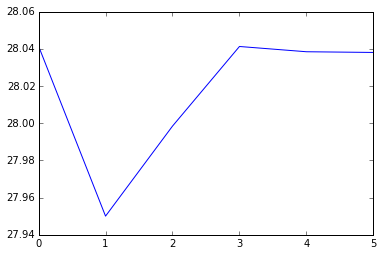

In [78]:
plt.plot(range(len(errs)), errs)

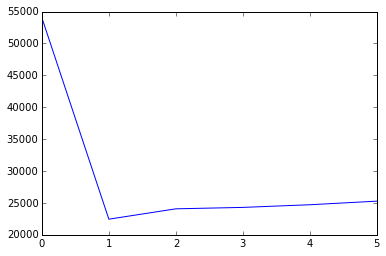

In [79]:
plt.plot(range(len(dists)), dists)

/home/zach/envs/thesis/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/zach/envs/thesis/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/zach/envs/thesis/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


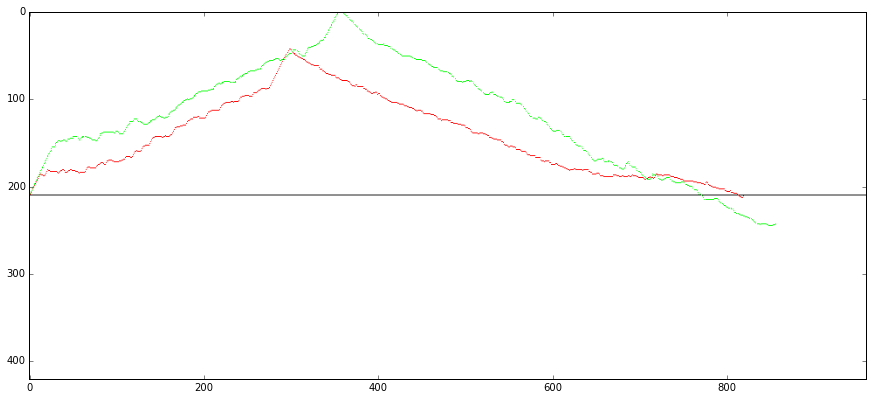

In [80]:
visualize_paths(p1_c, np.dot(p2_c, transforms[-1]))

In [15]:
#TODO Move this out of this notebook
import random
import utool as ut
def triplet_eval(curvatures, dist_method, compare_on, n_triplets=200):
    # generate triplets
    # the idea of a triplet is that we have an anchor sample and two other samples
    # one with the same id as the anchor and the other with a different id
    # (a1, a2, b) and we count a 0 if dist(a1,a2) < dist(a1,b) 
    # this way we can evaluate a distance method using 2*n_triplets comparisons,
    # which is significantly faster
    id_curv_map = {}
    for curv in curvatures:
        if curv['id'] in id_curv_map:
            id_curv_map[curv['id']].append(curv)
        else:
            id_curv_map[curv['id']] = [curv]
    #print(len(id_curv_map))
    good_count = 0
    # for complete coverage we'll generate a triplet for at most each id
    idlist = filter(lambda x: len(id_curv_map[x]) > 1, id_curv_map.keys())
    for _ in range(n_triplets):
        anchor = random.choice(idlist)
        random.shuffle(id_curv_map[anchor])
        negative = random.choice(filter(lambda x: x != anchor, idlist))
        random.shuffle(id_curv_map[negative])
        anchor_pos_dist = dist_method(id_curv_map[anchor][0], id_curv_map[anchor][1],
                                     compare_on=compare_on)
        anchor_neg_dist = dist_method(id_curv_map[anchor][0], id_curv_map[negative][0],
                                     compare_on=compare_on)
        if anchor_pos_dist < anchor_neg_dist:
            good_count += 1
            
    return good_count / float(n_triplets)

triplet_eval(curvatures, aidtw, 'path', n_triplets=1000)

0.69

In [16]:
def cpp_dtw_dist(c1, c2, compare_on='path'):
    # HACK
    if compare_on == 'int_curv':
        c1 = c1[compare_on]
        c2 = c2[compare_on]
        compare_on = 5
    c1 = np.array(c1[compare_on])
    c2 = np.array(c2[compare_on])
    distmat = get_dist_mat(c1, c2)
    return distmat[-1,-1]

def int_curv_dist(c1, c2):
    curv1 = np.array(c1[5])
    curv2 = np.array(c2[5])
    distmat = get_dist_mat(curv1, curv2)
    return distmat[-1,-1]

triplet_eval(curvatures, cpp_dtw_dist, 'int_curv', n_triplets=1000)

0.795

In [17]:
def aidtw_curvinit(c1, c2, compare_on='path'):
    initial_distmat = get_dist_mat(np.array(c1['int_curv'][5]),
                                   np.array(c2['int_curv'][5]))
    return aidtw(c1, c2, compare_on=compare_on, startmat=initial_distmat)

In [18]:
triplet_eval(curvatures, aidtw_curvinit, 'path', n_triplets=1000)

0.712

In [19]:
initial_distmat = get_dist_mat(np.array(c1['int_curv'][5]),
                                   np.array(c2['int_curv'][5]))
_, errs, dists, transforms = transformed_dist(c1['path'], c2['path'], startmat=initial_distmat)

/home/zach/envs/thesis/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


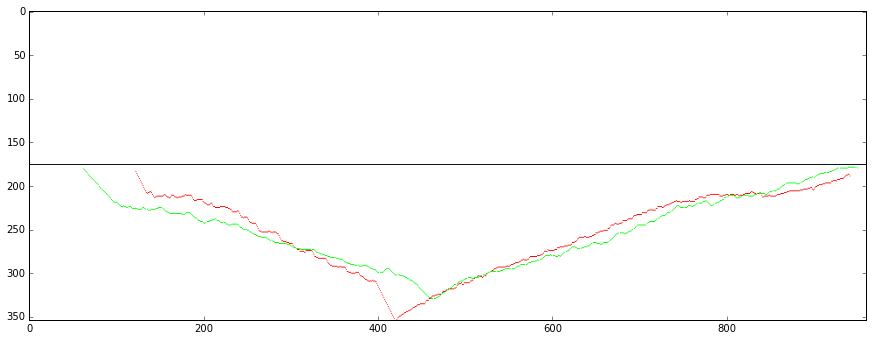

In [20]:
visualize_paths(np.array(c1['path']), 
                         np.dot(c2['path'], transforms[-1]))

In [21]:
transforms[-1]

array([[  1.05464010e+00,  -7.71566905e-04,   9.91983559e-04],
       [ -2.22423444e-02,   5.36316982e-01,   3.08098989e-03]])

In [39]:
def rank_eval(curvatures, dist_method=cpp_dtw_dist, compare_on='diffhist', k=5, verbose=0, sample_size=None):
    found_ins = [0]*(k+1)
    tic = time.time()
    hist = {}
    for c in curvatures:
        if c['id'] not in hist:
            hist[c['id']] = 1
        else:
            hist[c['id']] += 1
    bad_ids = set(filter(lambda x: hist[x] == 1, hist.keys()))
    random.shuffle(curvatures)
    if sample_size is None:
        upto = len(curvatures)
    else:
        upto = sample_size
    for qimg in ut.ProgressIter(range(upto), lbl='QueryImage', enabled=(verbose > 0)):
        if curvatures[qimg]['id'] in bad_ids:
            continue
        db = [c for ind, c in enumerate(curvatures) if ind != qimg]
        #db = curvatures
        dists = {}
        eval_tic = time.time()
        for db_c in ut.ProgressIter(db, lbl='dist', enabled=(verbose > 1)):
            single_tic = time.time()
            distance = dist_method(curvatures[qimg], db_c, compare_on=compare_on)
            if db_c['id'] not in dists:
                dists[db_c['id']] = [distance]
            else:
                dists[db_c['id']].append(distance)
            single_toc = time.time() - single_tic
            #if verbose > 1:
            #    print(single_toc)
        dists = {crcid:np.average(dists[crcid]) for crcid in dists}
        #print(dists[curvatures[qimg]['id']])
        top_k = sorted(dists.keys(),key=lambda x: dists[x])[:k]
        try:
            found_k = top_k.index(curvatures[qimg]['id'])
        except ValueError:
            found_k = -1
        if verbose > 0:
            print("Average distance for correct id: %0.2f, giving k=%d" % (dists[curvatures[qimg]['id']],
                                                                           found_k))
            print("Distance for k=0: %0.2f" % dists[top_k[0]])
        found_ins[found_k] += 1
        eval_toc = time.time() - eval_tic
        #if verbose > 0:
        #    print("Took %0.2f seconds to evaluate image %d" % (eval_toc, qimg))
    toc = time.time() - tic
    print("Took %0.2f seconds" % toc)
    found_ins = [f_in / upto for f_in in found_ins]
    return found_ins

In [ ]:
aidtw_eval = rank_eval(curvatures, dist_method=aidtw, compare_on='path', verbose=1, sample_size=100)

QueryImage    0/100...  Average distance for correct id: 1452.20, giving k=0
Distance for k=0: 1452.20
QueryImage    1/100...  rate=0.01 Hz, etr: 3:57:59, ellapsed: 0:02:24, wall: 14:12 EST
Average distance for correct id: 13142.13, giving k=-1
Distance for k=0: 3927.08
QueryImage    2/100...  rate=0.01 Hz, etr: 3:48:41, ellapsed: 0:04:44, wall: 14:14 EST
Average distance for correct id: 1923.69, giving k=0
Distance for k=0: 1923.69
QueryImage    3/100...  rate=0.01 Hz, etr: 3:49:49, ellapsed: 0:07:06, wall: 14:17 EST
Average distance for correct id: 29487.05, giving k=-1
Distance for k=0: 5964.22
QueryImage    4/100...  rate=0.01 Hz, etr: 3:44:44, ellapsed: 0:09:26, wall: 14:19 EST
Average distance for correct id: 4806.14, giving k=-1
Distance for k=0: 2913.33
QueryImage    5/100...  rate=0.01 Hz, etr: 3:45:25, ellapsed: 0:11:49, wall: 14:21 EST
Average distance for correct id: 4379.06, giving k=-1
Distance for k=0: 3380.52
QueryImage    6/100...  rate=0.01 Hz, etr: 3:45:29, ellapsed:

In [47]:
print(aidtw_eval)


[0.19, 0.04, 0.01, 0.01, 0.04, 0.71]


In [ ]:
aidtw_ci_eval = rank_eval(curvatures, dist_method=aidtw_curvinit, compare_on='path', verbose=1, sample_size=50)

In [46]:
print(aidtw_ci_eval)

[0.22, 0.06, 0.02, 0.0, 0.04, 0.66]


In [63]:
from functools import partial

def homog_aidtw(c1, c2, compare_on='path'):
    return aidtw(c1, c2, compare_on=compare_on, startmat=None, transform='homog')

def homog_aidtw_curvinit(c1, c2, compare_on='path'):
    initial_distmat = get_dist_mat(np.array(c1['int_curv'][5]),
                                   np.array(c2['int_curv'][5]))
    return aidtw(c1, c2, compare_on=compare_on, startmat=initial_distmat, transform='homog')

In [64]:
from inspect import getargspec
getargspec(aidtw)

ArgSpec(args=['c1', 'c2', 'compare_on', 'startmat', 'transform'], varargs=None, keywords=None, defaults=('path', None, 'affine'))

In [67]:
homog_aidtw_eval = rank_eval(curvatures, dist_method=homog_aidtw, compare_on='path', verbose=1, sample_size=100)

QueryImage    0/100...  Average distance for correct id: 6487.66, giving k=-1
Distance for k=0: 2319.01
QueryImage    1/100...  rate=0.01 Hz, etr: 3:58:14, ellapsed: 0:02:24, wall: 16:37 EST
Average distance for correct id: 3380.09, giving k=-1
Distance for k=0: 2529.40
QueryImage    2/100...  rate=0.01 Hz, etr: 3:53:51, ellapsed: 0:04:47, wall: 16:39 EST
Average distance for correct id: 4261.79, giving k=-1
Distance for k=0: 2509.15
QueryImage    3/100...  rate=0.01 Hz, etr: 3:50:51, ellapsed: 0:07:10, wall: 16:42 EST
Average distance for correct id: 2731.64, giving k=-1
Distance for k=0: 2102.61
QueryImage    4/100...  rate=0.01 Hz, etr: 3:57:55, ellapsed: 0:09:39, wall: 16:44 EST
Average distance for correct id: 3146.29, giving k=1
Distance for k=0: 3102.18
QueryImage    5/100...  rate=0.01 Hz, etr: 3:51:10, ellapsed: 0:12:05, wall: 16:47 EST
Average distance for correct id: 3394.93, giving k=-1
Distance for k=0: 2258.36
QueryImage    6/100...  rate=0.01 Hz, etr: 3:42:47, ellapsed: 

In [ ]:
print(homog_aidtw_eval)

[0.22, 0.05, 0.05, 0.02, 0.01, 0.65]


In [ ]:
homog_aidtw_ci_eval = rank_eval(curvatures, dist_method=homog_aidtw_curvinit, 
                             compare_on='path', verbose=1)

QueryImage    0/816...  Average distance for correct id: 16298.00, giving k=-1
Distance for k=0: 14897.19
QueryImage    1/816...  rate=0.01 Hz, etr: 1 day, 9:52:26, ellapsed: 0:02:29, wall: 11:14 EST
Average distance for correct id: 3329.23, giving k=-1
Distance for k=0: 2618.74
QueryImage    2/816...  rate=0.01 Hz, etr: 1 day, 9:14:27, ellapsed: 0:04:56, wall: 11:17 EST
Average distance for correct id: 4045.11, giving k=0
Distance for k=0: 4045.11
QueryImage    3/816...  rate=0.01 Hz, etr: 1 day, 9:22:32, ellapsed: 0:07:24, wall: 11:19 EST
Average distance for correct id: 1757.32, giving k=0
Distance for k=0: 1757.32
QueryImage    4/816...  rate=0.01 Hz, etr: 1 day, 9:01:25, ellapsed: 0:09:50, wall: 11:21 EST
Average distance for correct id: 2043.22, giving k=0
Distance for k=0: 2043.22
QueryImage    5/816...  rate=0.01 Hz, etr: 1 day, 9:44:51, ellapsed: 0:12:20, wall: 11:24 EST
Average distance for correct id: 4452.70, giving k=-1
Distance for k=0: 3626.29
QueryImage    6/816...  rat

In [73]:
print(homog_aidtw_ci_eval)

[0.39828431372549017, 0.06372549019607843, 0.03431372549019608, 0.028186274509803922, 0.014705882352941176, 0.45588235294117646]
